# Primer modelo lineal

Vamos a hacer nuestro primer modelo usando datos sintéticos para familiarizarnos con la sintaxis que cada una de las librerías requiere.

# Importaciones

In [1]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf # -> Así usaremos la notación formula
import statsmodels.api as sm # -> Así usaremos la notación de sklearn
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Generamos el conjunto de datos

Vamos a generar de manera sintética los datos necesarios para el siguiente modelo:

$$Y = \beta_0 + \beta_1 \boldsymbol X_1 + \boldsymbol\beta \boldsymbol X_{\text{clases}} + \varepsilon$$
$$\varepsilon \sim \mathsf{N}(0,\sigma^2)$$

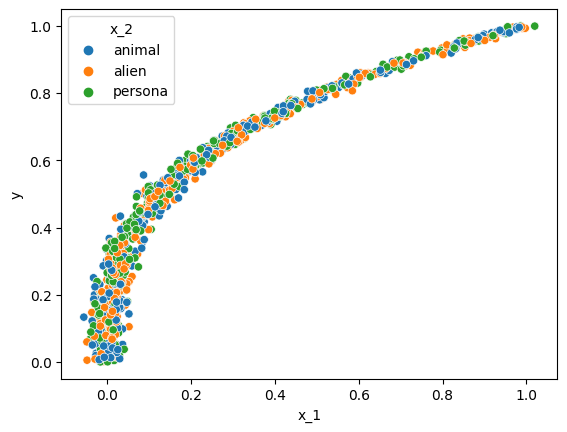

In [3]:
tamano = 1000
np.random.seed(100)

claves = {0:'persona', 1: 'animal', 2:'alien'}

# Predictores
y = np.random.random(tamano)
x_2 = [claves[i] for i in np.random.randint(0, 3, size=tamano)]

# Respuesta
x_1 = y ** 3 + np.random.normal(0, 0.02, tamano)

# Datos
data = pd.DataFrame({'y' : y, 'x_1' : x_1, 'x_2' : x_2})
sns.scatterplot(x = 'x_1', y = 'y', hue = 'x_2', data=data)

# Obtenemos las dummies
data = pd.get_dummies(data = data, )

y = data.loc[:, data.columns == "y"]
X = data.loc[:, data.columns != "y"]

Observamos que, como las clases se han obtenido de manera aleatoria, no tienen nada que ver con la variable respuesta. La variable que en cierta manera sí que tiene que ver con $Y$ es $X_1$ a través de la relación $Y = \sqrt[3]{X_1}$, sumando un poco de error normal, para añadir variabilidad al conjunto de datos.

In [4]:
data

y       x_1  x_2_alien  x_2_animal  x_2_persona
0    0.543405  0.162256      False        True        False
1    0.278369  0.004983       True       False        False
2    0.424518  0.064435      False       False         True
3    0.844776  0.577952      False       False         True
4    0.004719  0.017084      False       False         True
..        ...       ...        ...         ...          ...
995  0.656403  0.310452       True       False        False
996  0.291456  0.004109      False        True        False
997  0.150869  0.013256       True       False        False
998  0.036932  0.025943      False        True        False
999  0.597964  0.226430      False       False         True

[1000 rows x 5 columns]

# Modelo con 3 dummies

Ajustamos el modelo con las tres dummies.

In [5]:
lm = LinearRegression(fit_intercept = True) #Por defecto está a True
lm.fit(X = X, y = y)
print(lm.feature_names_in_)
print(lm.coef_[0])
print(lm.intercept_)

['x_1' 'x_2_alien' 'x_2_animal' 'x_2_persona']
[9.17617295e-01 3.59386793e+12 3.59386793e+12 3.59386793e+12]
[-3.59386793e+12]


Los valores de entrada y los de salida tienen valores comprendidos más o menos entre 0 y 1. Pese a que no da error, las estimaciones de los parámetros $\boldsymbol \beta$ que acompañanan a las clases, son del orden de `e+12`, esto quiere decir que `3.59386793e+12 = 3593867930000`, `3.59386793e+12 = 3593867930000` y `3.59386793e+12 = 3593867930000`, por lo que el modelo nos quedaría:

$$Y = -3593867930000 + 0.9176 X_1 + 3593867930000 \cdot \text{Persona} + 3593867930000 \cdot \text{Animal} + 3593867930000 \cdot  \text{Alien} + \varepsilon$$

Aquí hay claramente algo mal. Siempre una de las tres clases, `Persona`, `Animal` o `Alien` será 1, por lo que el valor `3593867930000` siempre estará presente en la combinación lineal, al igual, que el valor del intercepto, `-3593867930000`. Estos dos valores, son exactamente iguales por lo que se están cancelando entre sí.

Probemos con la otra librería a ver qué nos resultados nos da.

In [6]:
modelo = smf.ols(formula = 'y ~ x_1 + x_2_alien + x_2_animal + x_2_persona', data = data)
results = modelo.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     1662.
Date:                Sat, 20 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:57:49   Log-Likelihood:                 724.89
No. Observations:                1000   AIC:                            -1442.
Df Residuals:                     996   BIC:                            -1422.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.2038      0.004     55.359      0.000       0.197       0.211
x_2_alien[T.True]       0.0634      0.005     11.833      0.000       0.053       0.074
x_2_animal[T.True]      0.0663      0.005     12.325      0.000       0.056       0.077
x_2_persona[T.True]     0.0741      0.005     13.545      0.000       0.063       0.085
x_1                     0.9176      0.013     70.528      0.000       0.892       0.943
==============================================================================
Omnibus:                      165.411   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.314
Skew:                          -0.564   Prob(JB):                     2.98e-19
Kurtosis:                       2.120   Cond. No.                     1.09e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.17e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

$$Y = 0.2038 + 0.9176 X_1 + 0.0741 \cdot \text{Persona} + 0.0663 \cdot \text{Animal} + 0.0634 \cdot  \text{Alien} + \varepsilon$$

$$Y = 0.2038 + 0.9176 X_1 + 0.0741 \cdot \text{Persona} + 0.0663 \cdot \text{Animal} + \varepsilon$$

Parece ser que existe un problema con los $\boldsymbol\beta$ relacionados con la variable categórica. Aunque en este caso, sí que parece estar dando resultados comprensibles. ¿Dónde está el error?

Observemos la segunda nota: `The smallest eigenvalue is 7.2e-30. This might indicate that there are strong multicollinearity problems or that the design matrix is singular`. Este modelo, a diferencia del otro te está diciendo que la matriz es singular, es decir, que la inversa no existe.

Vamos a eliminar una de las tres dummies que nos está causando problemas y reejecutamos los resultados.

In [7]:
del data['x_2_persona']

y = data.loc[:, data.columns == "y"]
X = data.loc[:, data.columns != "y"]

In [8]:
lm = LinearRegression(fit_intercept = True)
lm.fit(X = X, y = y)
print(lm.feature_names_in_)
print(lm.coef_[0])
print(lm.intercept_)

['x_1' 'x_2_alien' 'x_2_animal']
[ 0.9176173  -0.01065575 -0.00773274]
[0.27783391]


In [9]:
modelo = smf.ols(formula = 'y ~ x_1 + x_2_alien + x_2_animal', data = data)
results = modelo.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     1662.
Date:                Sat, 20 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:57:49   Log-Likelihood:                 724.89
No. Observations:                1000   AIC:                            -1442.
Df Residuals:                     996   BIC:                            -1422.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2778      0.007     38.323      0.000       0.264       0.292
x_2_alien[T.True]     -0.0107      0.009     -1.168      0.243      -0.029       0.007
x_2_animal[T.True]    -0.0077      0.009     -0.839      0.402      -0.026       0.010
x_1                    0.9176      0.013     70.528      0.000       0.892       0.943
==============================================================================
Omnibus:                      165.411   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.314
Skew:                          -0.564   Prob(JB):                     2.98e-19
Kurtosis:                       2.120   Cond. No.                         4.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Creamos un nuevo modelo en el que eliminamos las varaibles dummy pues no son significativas.

In [10]:
modelo = smf.ols(formula = 'y ~ x_1', data = data)
results = modelo.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     4987.
Date:                Sat, 20 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:57:49   Log-Likelihood:                 724.17
No. Observations:                1000   AIC:                            -1444.
Df Residuals:                     998   BIC:                            -1435.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2717      0.005     55.384      0.000       0.262       0.281
x_1            0.9169      0.013     70.616      0.000       0.891       0.942
==============================================================================
Omnibus:                      167.918   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.941
Skew:                          -0.560   Prob(JB):                     3.59e-19
Kurtosis:                       2.114   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

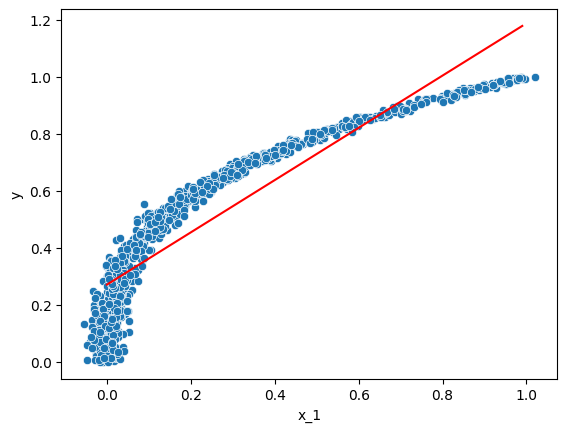

In [11]:
x_1_preds = [i for i in np.arange(0.0, 1.0, 0.01)]
y_hat = results.predict({'x_1': x_1_preds})
preds = {'x' : x_1_preds, 'y_hat': y_hat}

sns.scatterplot(x = 'x_1', y = 'y', data=data)
sns.lineplot(x = 'x', y = 'y_hat', data = preds, color = 'red')
plt.show()

El mensaje de la matriz singular se ha ido y los coeficientes usando los dos métodos son exacamente iguales. Pese a no haber saltado ningún error, existían incongruencias en los datos de entrada. ¡Hay que tener mucho cuidado con lo que le proporcionamos a los modelos!